# Library

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
# Others
import shutil
import random

# Load dataset

In [4]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Corn/train",
    label_mode="categorical",
    class_names=['Corn Gray leaf spot','Corn healthy','Corn leaf blight','Corn rust leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Corn/valid",
    label_mode="categorical",
    class_names=['Corn Gray leaf spot','Corn healthy','Corn leaf blight','Corn rust leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 7665 files belonging to 4 classes.
==========================Validation Data====================
Found 1855 files belonging to 4 classes.


In [5]:
# All images will be rescaled by 1./255.and augmented
train_datagen = ImageDataGenerator(rescale = 1.0/256.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("Dataset/Corn/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("Dataset/Corn/valid",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 7665 images belonging to 4 classes.
Found 1855 images belonging to 4 classes.


# List Resource

In [6]:
# Check GPU
!nvidia-smi

Tue May 30 10:18:50 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 532.03                 Driver Version: 532.03       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 L...  WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   55C    P0               39W /  N/A|   4628MiB /  6144MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Modelling With Augmentation

## DenseNet Model 1

In [9]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Corn_DenseNet_model1_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [10]:
# Define DIY Model
DenseNet_model = tf.keras.models.Sequential([
    # DenseNet121 Layer
    DenseNet121(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
DenseNet_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DenseNet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_max_pooling2d (Globa  (None, 1024)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 7,300,932
Trainable params: 7,217,284
Non-trainable params: 83,648
_________________________________________

In [11]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DenseNet_model_1 = DenseNet_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
384/384 [==============================] - ETA: 0s - loss: 0.6722 - accuracy: 0.8453
Epoch 1: val_accuracy improved from -inf to 0.78437, saving model to Corn_DenseNet_model1_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Augmented\assets


384/384 [==============================] - 163s 373ms/step - loss: 0.6722 - accuracy: 0.8453 - val_loss: 0.6189 - val_accuracy: 0.7844 - lr: 0.0010
Epoch 2/100
384/384 [==============================] - ETA: 0s - loss: 0.2848 - accuracy: 0.9059
Epoch 2: val_accuracy improved from 0.78437 to 0.93962, saving model to Corn_DenseNet_model1_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Augmented\assets


384/384 [==============================] - 107s 277ms/step - loss: 0.2848 - accuracy: 0.9059 - val_loss: 0.1851 - val_accuracy: 0.9396 - lr: 0.0010
Epoch 3/100
384/384 [==============================] - ETA: 0s - loss: 0.2450 - accuracy: 0.9114
Epoch 3: val_accuracy did not improve from 0.93962
384/384 [==============================] - 73s 188ms/step - loss: 0.2450 - accuracy: 0.9114 - val_loss: 0.1828 - val_accuracy: 0.9358 - lr: 0.0010
Epoch 4/100
384/384 [==============================] - ETA: 0s - loss: 0.2182 - accuracy: 0.9280
Epoch 4: val_accuracy improved from 0.93962 to 0.94016, saving model to Corn_DenseNet_model1_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Augmented\assets


384/384 [==============================] - 110s 287ms/step - loss: 0.2182 - accuracy: 0.9280 - val_loss: 0.1747 - val_accuracy: 0.9402 - lr: 0.0010
Epoch 5/100
384/384 [==============================] - ETA: 0s - loss: 0.2157 - accuracy: 0.9284
Epoch 5: val_accuracy did not improve from 0.94016
384/384 [==============================] - 78s 203ms/step - loss: 0.2157 - accuracy: 0.9284 - val_loss: 0.7484 - val_accuracy: 0.7412 - lr: 0.0010
Epoch 6/100
384/384 [==============================] - ETA: 0s - loss: 0.1928 - accuracy: 0.9303
Epoch 6: val_accuracy did not improve from 0.94016
384/384 [==============================] - 83s 216ms/step - loss: 0.1928 - accuracy: 0.9303 - val_loss: 0.2751 - val_accuracy: 0.8922 - lr: 0.0010
Epoch 7/100
384/384 [==============================] - ETA: 0s - loss: 0.1554 - accuracy: 0.9435
Epoch 7: val_accuracy improved from 0.94016 to 0.96065, saving model to Corn_DenseNet_model1_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Augmented\assets


384/384 [==============================] - 123s 319ms/step - loss: 0.1554 - accuracy: 0.9435 - val_loss: 0.1235 - val_accuracy: 0.9606 - lr: 0.0010
Epoch 8/100
384/384 [==============================] - ETA: 0s - loss: 0.1830 - accuracy: 0.9341
Epoch 8: val_accuracy did not improve from 0.96065
384/384 [==============================] - 77s 201ms/step - loss: 0.1830 - accuracy: 0.9341 - val_loss: 0.9351 - val_accuracy: 0.7881 - lr: 0.0010
Epoch 9/100
384/384 [==============================] - ETA: 0s - loss: 0.1821 - accuracy: 0.9346
Epoch 9: val_accuracy did not improve from 0.96065
384/384 [==============================] - 83s 215ms/step - loss: 0.1821 - accuracy: 0.9346 - val_loss: 0.1546 - val_accuracy: 0.9402 - lr: 0.0010
Epoch 10/100
384/384 [==============================] - ETA: 0s - loss: 0.1451 - accuracy: 0.9466
Epoch 10: val_accuracy did not improve from 0.96065
384/384 [==============================] - 81s 212ms/step - loss: 0.1451 - accuracy: 0.9466 - val_loss: 0.1160 -

INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Augmented\assets


384/384 [==============================] - 117s 306ms/step - loss: 0.1306 - accuracy: 0.9532 - val_loss: 0.0787 - val_accuracy: 0.9730 - lr: 0.0010
Epoch 15/100
384/384 [==============================] - ETA: 0s - loss: 0.2691 - accuracy: 0.9083
Epoch 15: val_accuracy did not improve from 0.97305
384/384 [==============================] - 76s 198ms/step - loss: 0.2691 - accuracy: 0.9083 - val_loss: 3.4499 - val_accuracy: 0.5062 - lr: 0.0010
Epoch 16/100
384/384 [==============================] - ETA: 0s - loss: 0.1712 - accuracy: 0.9417
Epoch 16: val_accuracy did not improve from 0.97305
384/384 [==============================] - 76s 198ms/step - loss: 0.1712 - accuracy: 0.9417 - val_loss: 0.1200 - val_accuracy: 0.9590 - lr: 0.0010
Epoch 17/100
384/384 [==============================] - ETA: 0s - loss: 0.1434 - accuracy: 0.9455
Epoch 17: val_accuracy did not improve from 0.97305
384/384 [==============================] - 80s 208ms/step - loss: 0.1434 - accuracy: 0.9455 - val_loss: 0.10

INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Augmented\assets


384/384 [==============================] - 117s 305ms/step - loss: 0.0979 - accuracy: 0.9633 - val_loss: 0.0558 - val_accuracy: 0.9811 - lr: 1.0000e-04
Epoch 21/100
384/384 [==============================] - ETA: 0s - loss: 0.0900 - accuracy: 0.9659
Epoch 21: val_accuracy improved from 0.98113 to 0.98221, saving model to Corn_DenseNet_model1_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Augmented\assets


384/384 [==============================] - 117s 303ms/step - loss: 0.0900 - accuracy: 0.9659 - val_loss: 0.0508 - val_accuracy: 0.9822 - lr: 1.0000e-04
Epoch 22/100
384/384 [==============================] - ETA: 0s - loss: 0.0797 - accuracy: 0.9703
Epoch 22: val_accuracy did not improve from 0.98221
384/384 [==============================] - 78s 202ms/step - loss: 0.0797 - accuracy: 0.9703 - val_loss: 0.0545 - val_accuracy: 0.9806 - lr: 1.0000e-04
Epoch 23/100
384/384 [==============================] - ETA: 0s - loss: 0.0777 - accuracy: 0.9723
Epoch 23: val_accuracy did not improve from 0.98221
384/384 [==============================] - 82s 212ms/step - loss: 0.0777 - accuracy: 0.9723 - val_loss: 0.0638 - val_accuracy: 0.9795 - lr: 1.0000e-04
Epoch 24/100
384/384 [==============================] - ETA: 0s - loss: 0.0760 - accuracy: 0.9704
Epoch 24: val_accuracy improved from 0.98221 to 0.98275, saving model to Corn_DenseNet_model1_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Augmented\assets


384/384 [==============================] - 125s 324ms/step - loss: 0.0760 - accuracy: 0.9704 - val_loss: 0.0442 - val_accuracy: 0.9827 - lr: 1.0000e-04
Epoch 25/100
384/384 [==============================] - ETA: 0s - loss: 0.0730 - accuracy: 0.9727
Epoch 25: val_accuracy did not improve from 0.98275
384/384 [==============================] - 83s 215ms/step - loss: 0.0730 - accuracy: 0.9727 - val_loss: 0.0714 - val_accuracy: 0.9714 - lr: 1.0000e-04
Epoch 26/100
384/384 [==============================] - ETA: 0s - loss: 0.0678 - accuracy: 0.9747
Epoch 26: val_accuracy improved from 0.98275 to 0.98868, saving model to Corn_DenseNet_model1_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DenseNet_model1_Based_Augmented\assets


384/384 [==============================] - 120s 312ms/step - loss: 0.0678 - accuracy: 0.9747 - val_loss: 0.0398 - val_accuracy: 0.9887 - lr: 1.0000e-04
Epoch 27/100
384/384 [==============================] - ETA: 0s - loss: 0.0685 - accuracy: 0.9748
Epoch 27: val_accuracy did not improve from 0.98868
384/384 [==============================] - 79s 203ms/step - loss: 0.0685 - accuracy: 0.9748 - val_loss: 0.0417 - val_accuracy: 0.9844 - lr: 1.0000e-04
Epoch 28/100
384/384 [==============================] - ETA: 0s - loss: 0.0668 - accuracy: 0.9750
Epoch 28: val_accuracy did not improve from 0.98868
384/384 [==============================] - 80s 209ms/step - loss: 0.0668 - accuracy: 0.9750 - val_loss: 0.0453 - val_accuracy: 0.9827 - lr: 1.0000e-04
Epoch 29/100
384/384 [==============================] - ETA: 0s - loss: 0.0685 - accuracy: 0.9730
Epoch 29: val_accuracy did not improve from 0.98868
384/384 [==============================] - 83s 216ms/step - loss: 0.0685 - accuracy: 0.9730 - va

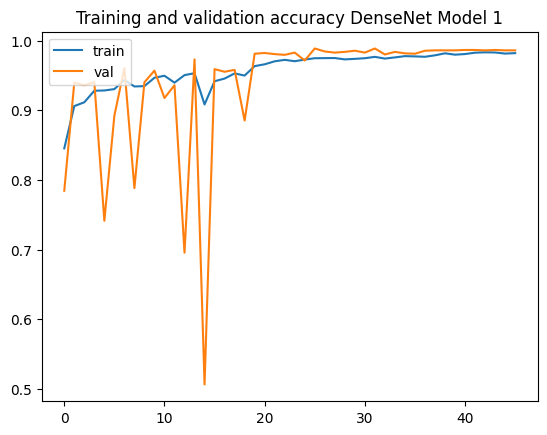

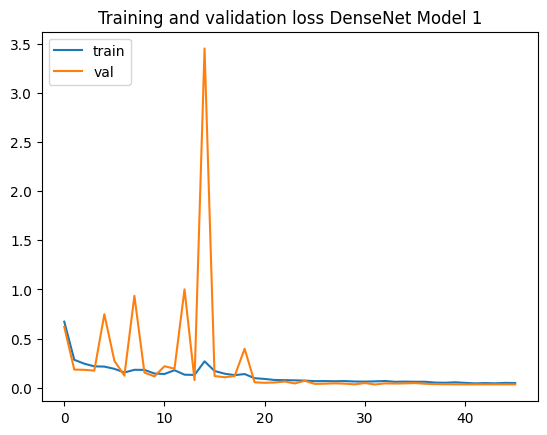

In [12]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DenseNet_model_1.history['accuracy' ]
val_acc  = history_DenseNet_model_1.history['val_accuracy' ]
loss     = history_DenseNet_model_1.history['loss' ]
val_loss = history_DenseNet_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DenseNet Model 1')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DenseNet Model 1')
plt.legend(['train', 'val'], loc='upper left')

## DenseNet Model 2

In [13]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Corn_DenseNet_model2_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [14]:
# Define DIY Model
DenseNet_model_2 = tf.keras.models.Sequential([
    # DenseNet121 Layer
    DenseNet121(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
DenseNet_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DenseNet_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 7,300,932
Trainable params: 7,217,284
Non-trainable params: 83,648
_______________________________________

In [15]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DenseNet_model_2 = DenseNet_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
384/384 [==============================] - ETA: 0s - loss: 0.3000 - accuracy: 0.8879
Epoch 1: val_accuracy improved from -inf to 0.73261, saving model to Corn_DenseNet_model2_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DenseNet_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DenseNet_model2_Based_Augmented\assets


384/384 [==============================] - 134s 317ms/step - loss: 0.3000 - accuracy: 0.8879 - val_loss: 1.1845 - val_accuracy: 0.7326 - lr: 0.0010
Epoch 2/100
384/384 [==============================] - ETA: 0s - loss: 0.1966 - accuracy: 0.9279
Epoch 2: val_accuracy did not improve from 0.73261
384/384 [==============================] - 82s 214ms/step - loss: 0.1966 - accuracy: 0.9279 - val_loss: 1.1056 - val_accuracy: 0.6323 - lr: 0.0010
Epoch 3/100
384/384 [==============================] - ETA: 0s - loss: 0.1616 - accuracy: 0.9383
Epoch 3: val_accuracy did not improve from 0.73261
384/384 [==============================] - 83s 216ms/step - loss: 0.1616 - accuracy: 0.9383 - val_loss: 1.6848 - val_accuracy: 0.6437 - lr: 0.0010
Epoch 4/100
384/384 [==============================] - ETA: 0s - loss: 0.1522 - accuracy: 0.9440
Epoch 4: val_accuracy improved from 0.73261 to 0.93208, saving model to Corn_DenseNet_model2_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DenseNet_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DenseNet_model2_Based_Augmented\assets


384/384 [==============================] - 123s 320ms/step - loss: 0.1522 - accuracy: 0.9440 - val_loss: 0.1891 - val_accuracy: 0.9321 - lr: 0.0010
Epoch 5/100
384/384 [==============================] - ETA: 0s - loss: 0.1287 - accuracy: 0.9502
Epoch 5: val_accuracy improved from 0.93208 to 0.95364, saving model to Corn_DenseNet_model2_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DenseNet_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DenseNet_model2_Based_Augmented\assets


384/384 [==============================] - 132s 343ms/step - loss: 0.1287 - accuracy: 0.9502 - val_loss: 0.1269 - val_accuracy: 0.9536 - lr: 0.0010
Epoch 6/100
384/384 [==============================] - ETA: 0s - loss: 0.1527 - accuracy: 0.9462
Epoch 6: val_accuracy did not improve from 0.95364
384/384 [==============================] - 95s 246ms/step - loss: 0.1527 - accuracy: 0.9462 - val_loss: 0.5757 - val_accuracy: 0.8313 - lr: 0.0010
Epoch 7/100
384/384 [==============================] - ETA: 0s - loss: 0.1339 - accuracy: 0.9495
Epoch 7: val_accuracy did not improve from 0.95364
384/384 [==============================] - 96s 251ms/step - loss: 0.1339 - accuracy: 0.9495 - val_loss: 0.6834 - val_accuracy: 0.7854 - lr: 0.0010
Epoch 8/100
384/384 [==============================] - ETA: 0s - loss: 0.1297 - accuracy: 0.9525
Epoch 8: val_accuracy did not improve from 0.95364
384/384 [==============================] - 88s 229ms/step - loss: 0.1297 - accuracy: 0.9525 - val_loss: 0.1628 - v

INFO:tensorflow:Assets written to: Corn_DenseNet_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DenseNet_model2_Based_Augmented\assets


384/384 [==============================] - 130s 338ms/step - loss: 0.1269 - accuracy: 0.9529 - val_loss: 0.1328 - val_accuracy: 0.9547 - lr: 0.0010
Epoch 10/100
384/384 [==============================] - ETA: 0s - loss: 0.1151 - accuracy: 0.9562
Epoch 10: val_accuracy did not improve from 0.95472

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
384/384 [==============================] - 97s 251ms/step - loss: 0.1151 - accuracy: 0.9562 - val_loss: 0.7203 - val_accuracy: 0.8054 - lr: 0.0010
Epoch 11/100
384/384 [==============================] - ETA: 0s - loss: 0.0945 - accuracy: 0.9654
Epoch 11: val_accuracy improved from 0.95472 to 0.98167, saving model to Corn_DenseNet_model2_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DenseNet_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DenseNet_model2_Based_Augmented\assets


384/384 [==============================] - 146s 380ms/step - loss: 0.0945 - accuracy: 0.9654 - val_loss: 0.0507 - val_accuracy: 0.9817 - lr: 1.0000e-04
Epoch 12/100
384/384 [==============================] - ETA: 0s - loss: 0.0748 - accuracy: 0.9731
Epoch 12: val_accuracy did not improve from 0.98167
384/384 [==============================] - 91s 236ms/step - loss: 0.0748 - accuracy: 0.9731 - val_loss: 0.0668 - val_accuracy: 0.9725 - lr: 1.0000e-04
Epoch 13/100
384/384 [==============================] - ETA: 0s - loss: 0.0715 - accuracy: 0.9736
Epoch 13: val_accuracy did not improve from 0.98167
384/384 [==============================] - 91s 237ms/step - loss: 0.0715 - accuracy: 0.9736 - val_loss: 0.0604 - val_accuracy: 0.9817 - lr: 1.0000e-04
Epoch 14/100
384/384 [==============================] - ETA: 0s - loss: 0.0694 - accuracy: 0.9751
Epoch 14: val_accuracy improved from 0.98167 to 0.98598, saving model to Corn_DenseNet_model2_Based_Augmented


INFO:tensorflow:Assets written to: Corn_DenseNet_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DenseNet_model2_Based_Augmented\assets


384/384 [==============================] - 137s 356ms/step - loss: 0.0694 - accuracy: 0.9751 - val_loss: 0.0425 - val_accuracy: 0.9860 - lr: 1.0000e-04
Epoch 15/100
384/384 [==============================] - ETA: 0s - loss: 0.0652 - accuracy: 0.9756
Epoch 15: val_accuracy did not improve from 0.98598
384/384 [==============================] - 92s 239ms/step - loss: 0.0652 - accuracy: 0.9756 - val_loss: 0.0499 - val_accuracy: 0.9844 - lr: 1.0000e-04
Epoch 16/100
384/384 [==============================] - ETA: 0s - loss: 0.0579 - accuracy: 0.9807
Epoch 16: val_accuracy did not improve from 0.98598
384/384 [==============================] - 96s 250ms/step - loss: 0.0579 - accuracy: 0.9807 - val_loss: 0.0525 - val_accuracy: 0.9806 - lr: 1.0000e-04
Epoch 17/100
384/384 [==============================] - ETA: 0s - loss: 0.0511 - accuracy: 0.9803
Epoch 17: val_accuracy did not improve from 0.98598
384/384 [==============================] - 98s 255ms/step - loss: 0.0511 - accuracy: 0.9803 - va

INFO:tensorflow:Assets written to: Corn_DenseNet_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DenseNet_model2_Based_Augmented\assets


384/384 [==============================] - 140s 364ms/step - loss: 0.0400 - accuracy: 0.9859 - val_loss: 0.0440 - val_accuracy: 0.9865 - lr: 1.0000e-06
Epoch 26/100
384/384 [==============================] - ETA: 0s - loss: 0.0425 - accuracy: 0.9836
Epoch 26: val_accuracy did not improve from 0.98652
384/384 [==============================] - 100s 260ms/step - loss: 0.0425 - accuracy: 0.9836 - val_loss: 0.0451 - val_accuracy: 0.9865 - lr: 1.0000e-06
Epoch 27/100
384/384 [==============================] - ETA: 0s - loss: 0.0447 - accuracy: 0.9850
Epoch 27: val_accuracy did not improve from 0.98652
384/384 [==============================] - 105s 273ms/step - loss: 0.0447 - accuracy: 0.9850 - val_loss: 0.0453 - val_accuracy: 0.9865 - lr: 1.0000e-06
Epoch 28/100
384/384 [==============================] - ETA: 0s - loss: 0.0421 - accuracy: 0.9836
Epoch 28: val_accuracy did not improve from 0.98652
384/384 [==============================] - 115s 298ms/step - loss: 0.0421 - accuracy: 0.9836 -

INFO:tensorflow:Assets written to: Corn_DenseNet_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_DenseNet_model2_Based_Augmented\assets


384/384 [==============================] - 174s 454ms/step - loss: 0.0413 - accuracy: 0.9837 - val_loss: 0.0434 - val_accuracy: 0.9871 - lr: 1.0000e-07
Epoch 32/100
384/384 [==============================] - ETA: 0s - loss: 0.0414 - accuracy: 0.9836
Epoch 32: val_accuracy did not improve from 0.98706
384/384 [==============================] - 98s 255ms/step - loss: 0.0414 - accuracy: 0.9836 - val_loss: 0.0435 - val_accuracy: 0.9865 - lr: 1.0000e-07
Epoch 33/100
384/384 [==============================] - ETA: 0s - loss: 0.0410 - accuracy: 0.9843
Epoch 33: val_accuracy did not improve from 0.98706
384/384 [==============================] - 104s 271ms/step - loss: 0.0410 - accuracy: 0.9843 - val_loss: 0.0439 - val_accuracy: 0.9865 - lr: 1.0000e-07
Epoch 34/100
384/384 [==============================] - ETA: 0s - loss: 0.0376 - accuracy: 0.9856
Epoch 34: val_accuracy did not improve from 0.98706

Epoch 34: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
384/384 [========

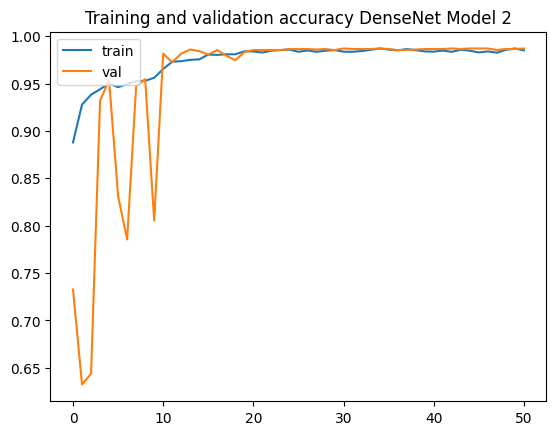

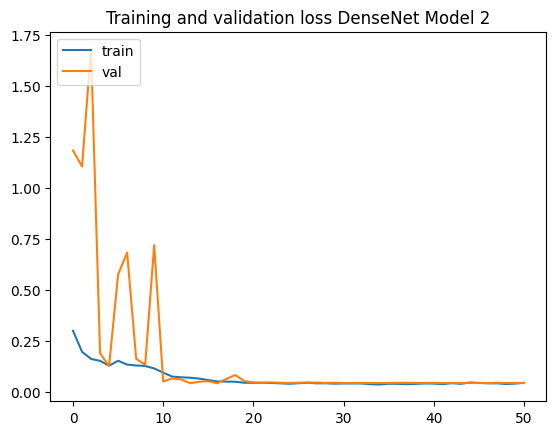

In [16]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DenseNet_model_2.history['accuracy' ]
val_acc  = history_DenseNet_model_2.history['val_accuracy' ]
loss     = history_DenseNet_model_2.history['loss' ]
val_loss = history_DenseNet_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DenseNet Model 2')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DenseNet Model 2')
plt.legend(['train', 'val'], loc='upper left')